In [1]:
import spot
spot.setup(show_default='.bn')
from IPython.display import display

# Stutter-invariant languages

A language $L$ is said to be _stutter-invariant_ iff $\ell_0\ldots\ell_{i-1}\ell_i\ell_{i+1}\ldots\in L \iff \ell_0\ldots\ell_{i-1}\ell_i\ell_i\ell_{i+1}\ldots\in L$, i.e., if duplicating a letter in a word or removing a duplicated letter does not change the membership of that word to $L$.  These languages are also called _stutter-insensitive_.   We use the adjective _sutter-sensitive_ to describe a language that is not stutter-invariant.   Of course we can extend this vocabulary to LTL formulas or automata that represent stutter-invariant languages.

Stutter-invariant languages play an important role in model checking.  When verifying a stutter-invariant specification against a system, we know that we have some freedom in how we discretize the time in the model: as long as we do not hide changes of model variables that are observed by the specification, we can merge multiple steps of the model.  This, combined by careful analysis of actions of the model that are independent, is the basis for a set of techniques known as _partial-order reductions_ (POR) that postpone the visit of some successors in the model, because we know we can always visit them later.

## Stutter-invariant formulas

When the specification is expressed as an LTL formula, a well known way to ensure it is _stutter-invariant_ is to forbid the use of the `X` operator.  Testing whether a formula is `X`-free can be done in constant time using the `is_syntactic_stutter_invariant()` method.

In [2]:
f = spot.formula('a U b')
print(f.is_syntactic_stutter_invariant())

True


In [3]:
f = spot.formula('a U Xb')
print(f.is_syntactic_stutter_invariant())

False


However some formula are syntactic-invariant despite their use of `X`.   Spot implements some [automaton-based check](https://www.lrde.epita.fr/~adl/dl/adl/michaud.15.spin.pdf) to detect stutter-invariance reliably and efficiently.  This can be tested with the `is_stutter_invariant()` function.

In [4]:
g = spot.formula('F(a & X(!a & Gb))')
print(g.is_syntactic_stutter_invariant())
print(spot.is_stutter_invariant(g))

False
True


Of course this `is_stutter_invariant()` function first checks whether the formula is `X`-free before wasting time building automata, so if you want to detect stutter-invariant formulas in your model checker, this is the only function to use.  Also, if you hapen to already have an automaton `aut_g` for `g`, you should pass it as a second argument to avoid it being recomputed: `spot.is_stutter_invariant(g, aut_g)`.

It is also known that any stutter-invariant LTL formula can be converted to an `X`-free LTL formula.  Several proofs of that exist.  Spot implements the rewriting of [K. Etessami](http://homepages.inf.ed.ac.uk/kousha/note_on_stut_tl_lpi.ps) under the name `remove_x()`.  Note that the output of this function is only equivalent to its input if the latter is stutter-invariant.

In [5]:
spot.remove_x(g)

spot.formula("F(a & ((a & (a U (!a & Gb)) & ((!b U !a) | (b U !a))) | (!a & (!a U (a & !a & Gb)) & ((!b U a) | (b U a))) | (b & (b U (!a & !b & Gb)) & ((!a U !b) | (a U !b))) | (!b & (!b U (!a & b & Gb)) & ((!a U b) | (a U b))) | (!a & Gb & (G!a | Ga) & (Gb | G!b))))")

## Stutter-invariant automata

Similarly to formulas, automata use a few bits to store some known properties about themselves, like whether they represent a stutter-invariant language.  This property can be checked with the `prop_stutter_invariant()` method, but that returns a `trival` instance (i.e., yes, no, or maybe).  Some algorithms will update that property whenever that is cheap or expliclitely asked for.   For instance `spot.translate()` only sets the property if the translated formula is `X`-free.

In [6]:
aut = spot.translate(g)
print(aut.prop_stutter_invariant())

maybe


As suggested above, we can call `is_stutter_invariant()` by passing a formula and its automaton, to save on one translation.  A second translation is still needed to complement the automaton.

In [7]:
print(spot.is_stutter_invariant(g, aut))

True


Note that `prop_stutter_invariant()` was updated as a side-effect so that any futher call to `is_stutter_invariant()` with this automaton will be instantaneous.

In [8]:
print(aut.prop_stutter_invariant())

yes


You have to be aware of this property being set in your back because if while playing with `is_stutter_invariant()` you the incorrect formula for an automaton by mistake, the automaton will have its property set incorrectly, and running `is_stutter_inariant()` with the correct formula will simply return the cached property.

In doubt, you can always reset the property as follows:

In [9]:
aut.prop_stutter_invariant(spot.trival_maybe())
print(aut.prop_stutter_invariant())

maybe


In case you have an automaton for which you do not have formula, you can also use `is_stutter_invariant()` by passing this automaton as the first argument.  In that case a negated automaton will be constructed by determinization.  If you do happen to have a negated automaton handy, you can pass it as a second argument to avoid that.

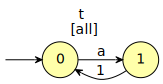

False


In [10]:
a1 = spot.automaton('''HOA: v1 
AP: 1 "a" 
States: 2 
Start: 0 
Acceptance: 0 t
--BODY-- 
State: 0 [0] 1 
State: 1 [t] 0 
--END--''')
display(a1)
print(spot.is_stutter_invariant(a1))

## Explaining why a formula is not sutter-invariant

As explained in our [Spin'15 paper](https://www.lrde.epita.fr/~adl/dl/adl/michaud.15.spin.pdf) the sutter-invariant checks are implemented using simple operators suchs as `spot.closure(aut)`, that augment the language of L by adding words that can be obtained by removing duplicated letters, and `spot.sl(aut)` or `spot.sl2(aut)` that both augment the language that L by adding words that can be obtained by duplicating letters.  The default `is_stutter_invariant()` function is implemented as `spot.product(spot.closure(aut), spot.closure(neg_aut)).is_empty()`, but that is just one possible implementation selected because it was more efficient.

Using these bricks, we can modify the original algorithm so it uses a counterexample to explain why a formula is stutter-sensitive.

In [11]:
def explain_stut(f):
    f = spot.formula(f)
    pos = spot.translate(f)
    neg = spot.translate(spot.formula.Not(f))
    word = spot.product(spot.closure(pos), spot.closure(neg)).accepting_word()
    if word is None:
        print(f, "is stutter invariant")
        return
    word.simplify()
    word.use_all_aps(pos.ap_vars())
    waut = word.as_automaton()
    if waut.intersects(pos):
        acc, rej, aut = "accepted", "rejected", neg
    else:
        acc, rej, aut = "rejected", "accepted", pos
    word2 = spot.sl2(waut).intersecting_word(aut)
    word2.simplify()
    print("""{} is {} by {}
  but if we stutter some of its letters, we get
{} which is {} by {}""".format(word, acc, f, word2, rej, f))

In [12]:
explain_stut('GF(a & Xb)')

cycle{!a & !b; a & b} is rejected by GF(a & Xb)
  but if we stutter some of its letters, we get
cycle{!a & !b; a & b; a & b} which is accepted by GF(a & Xb)


Note that a variant of the above explanation procedure is already integerated in our [on-line LTL translator tool](https://spot.lrde.epita.fr/app/) (use the <i>study</i> tab).

## Detecting stutter-invariant states

Even if the language of an automaton is not sutter invariant, some of its states may recognize a stutter-invariant language.  (We assume the language of a state is the language the automaton would have when starting from this state.)

### First example

For instance let us build a disjunction of a stutter-invariant formula and a stutter-sensitive one:

In [13]:
f1 = spot.formula('F(a & X!a & XF(b & X!b & Ga))')
f2 = spot.formula('F(a & Xa & XXa & G!b)')
f = spot.formula.Or([f1, f2])

print(spot.is_stutter_invariant(f1))
print(spot.is_stutter_invariant(f2))
print(spot.is_stutter_invariant(f))

True
False
False


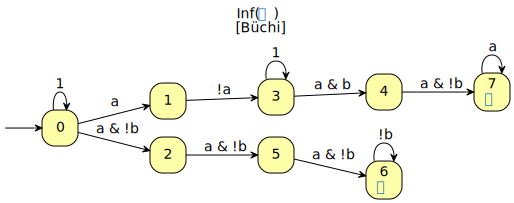

In [14]:
pos = spot.translate(f)
display(pos)

While the automaton as a whole is stutter-sensitive, we can see that eventually we will enter a sub-automaton that is stutter-invariant.

The `stutter_invariant_states()` function returns a Boolean vector indiced by the state number.  A state is marked as `True` if either its language is stutter-invariant, or if it can only be reached via a stutter-invariant state (see the second example later).  As always, the second argument, `f`, can be omitted (pass `None`) if the formula is unknown, or it can be replaced by a negated automaton if it is known. 

In [15]:
spot.stutter_invariant_states(pos, f)

(False, True, False, True, True, True, True, True)

For convenience, the `highligh_...()` version colors the stutter-invariant states of the automaton for display.
(That 5 is the color number for red in Spot's hard-coded palette.)

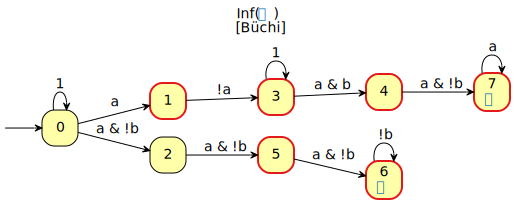

In [16]:
spot.highlight_stutter_invariant_states(pos, f, 5)
display(pos)

Such a procedure gives us a map of where POR can be enabled when model checking using this automaton.

### Second example

This second example illustrates the fact that a state can be marked if it it not sutter-invariant but appear below a stutter-invariant state.  We build our example automaton as the disjuction of the following two stutter-sensitive formulas, whose union is equivalent to the sutter-invariant formula `GF!a`.

In [17]:
g1 = spot.formula('GF(a & Xa) & GF!a')
g2 = spot.formula('!GF(a & Xa) & GF!a')
g = spot.formula.Or([g1, g2])

In [18]:
print(spot.is_stutter_invariant(g1))
print(spot.is_stutter_invariant(g2))
print(spot.is_stutter_invariant(g))

False
False
True


Here are the automata for `g1` and `g2`, note that none of the states are stutter-invariant.

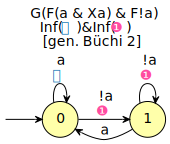

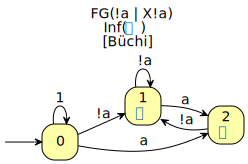

In [19]:
aut1 = spot.translate(g1)
aut1.set_name(str(g1))
spot.highlight_stutter_invariant_states(aut1, g1, 5)
display(aut1)

aut2 = spot.translate(g2)
aut2.set_name(str(g2))
spot.highlight_stutter_invariant_states(aut2, g2, 5)
display(aut2)

Now we build the sum of these two automata.  The stutter-invariance check detects that the initial state is stutter-invariant (i.e., the entire language is stutter-invariant) so all states below it are marked despite the fact that the language recognized from these individual states would not be stutter-invariant.

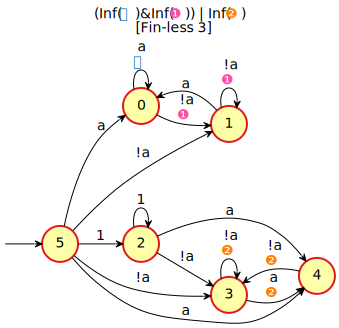

In [20]:
aut = spot.sum(aut1, aut2)
# At this point it is unknown if AUT is stutter-invariant
assert(aut.prop_stutter_invariant().is_maybe())
spot.highlight_stutter_invariant_states(aut, g, 5)
display(aut)
# The stutter_invariant property is set on AUT as a side effect
# of calling sutter_invariant_states() or any variant of it.
assert(aut.prop_stutter_invariant().is_true())

### Third example

These procedures work regardless of the acceptance condition.  Here is an example with co-Büchi acceptance.

In this case we do not even have a formula to pass as second argument, so the check will perform a complementation by determinization.

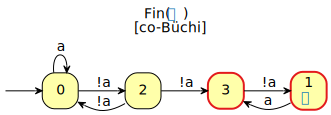

In [21]:
aut = spot.automaton('randaut --seed=30 -Q4 -A"Fin(0)" a |')
spot.highlight_stutter_invariant_states(aut, None, 5)
display(aut)

If the negated automaton is already known, it can be passed as second argument (instead of the positive formula) to avoid unnecessary work.

## Sutter-invariance at the letter level

Instead of marking each state as stuttering or not, we can list the letters that we can stutter in each state.
More precisely, a state $q$ is _stutter-invariant for letter $a$_ if the membership to $L(q)$ of any word starting with $a$ is preserved by the operations that duplicate letters or remove duplicates.   

$(\ell_0\ldots\ell_{i-1}\ell_i\ell_{i+1}\ldots\in L(q) \land \ell_0=a) \iff (\ell_0\ldots\ell_{i-1}\ell_i\ell_i\ell_{i+1}\ldots\in L(q)\land \ell_0=a)$

Under this definition, we can also say that $q$ is _stutter-invariant_ iff it is _stutter-invariant for any letter_.

For instance consider the following automaton, for which all words that start with $b$ are stutter invariant.
The initial state may not be declared as stutter-invariant because of words that start with $\lnot b$.

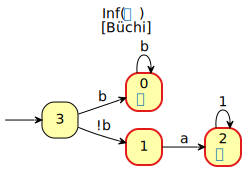

In [22]:
f = spot.formula('(!b&Xa) | Gb')
pos = spot.translate(f)
spot.highlight_stutter_invariant_states(pos, f, 5)
display(pos)

The `stutter_invariant_letters()` functions returns a vector of BDDs indexed by state numbers.  The BDD at index $q$ specifies all letters $\ell$ for which state $q$ would be stuttering.  Note that if $q$ is stutter-invariant or reachable from a stutter-invariant state, the associated BDD will be `bddtrue` (printed as `1` below).

This interface is a bit inconveniant to use interactively, due to the fact that we need a `spot.bdd_dict` object to print a BDD.

In [23]:
sil_vec = spot.stutter_invariant_letters(pos, f)
for q in range(pos.num_states()):
    print("sil_vec[{}] =".format(q), spot.bdd_format_formula(pos.get_dict(), sil_vec[q]))

sil_vec[0] = 1
sil_vec[1] = 1
sil_vec[2] = 1
sil_vec[3] = b


## The set of stutter-invariant states is not always forward closed

Consider the following automaton, which is a variant of our second example above.  

The language accepted from state (2) is `!GF(a & Xa) & GF!a` (this can be simplified to `FG(!a | X!a)`), while the language accepted from state (0) is `GF(a & Xa) & GF!a`.  Therefore. the language accepted from state (5) is `a & X(GF!a)`.  Since this is equivalent to `a & GF(!a)` state (5) recognizes stutter-invariant language, but as we can see, it is not the case that all states below (5) are also marked.  In fact, states (0) can also be reached via states (7) and (6), recognizing respectively  `(a & X(a & GF!a)) | (!a & X(!a & GF(a & Xa) & GF!a))` and `!a & GF(a & Xa) & GF!a))`, i.e., two stutter-sentive languages.

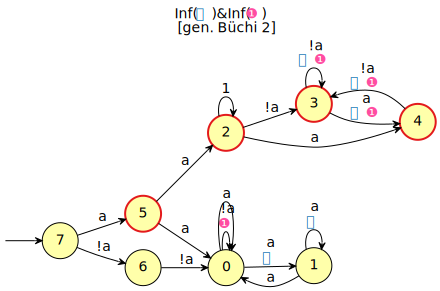

In [24]:
ex1 = spot.automaton("""HOA: v1 
States: 8 Start: 7 AP: 1 "a" Acceptance: 2 (Inf(0)&Inf(1))
--BODY--
State: 0 [!0] 0 {1} [0] 0 [0] 1 {0}
State: 1 [0] 0 [0] 1 {0}
State: 2 [t] 2 [!0] 3 [0] 4
State: 3 [!0] 3 {0 1} [0] 4 {0 1}
State: 4 [!0] 3 {0 1}
State: 5 [0] 0 [0] 2
State: 6 [!0] 0
State: 7 [!0] 6 [0] 5
--END--""")
spot.highlight_stutter_invariant_states(ex1, None, 5)
display(ex1)

This situation can be tested with `spot.is_stutter_invariant_forward_closed()`.  The function returns `-1` if the successor of any stutter-invariant state is it is also a stutter-invariant state, otherwise it return the number of one stutter-sensitive state that has a stutter-invariant state as predecessor.

In [25]:
sistates = spot.stutter_invariant_states(ex1)
spot.is_stutter_invariant_forward_closed(ex1, sistates)

0

In cases where we prefer to have a forward-closed set of stutter-invariant states, it is always possible to duplicate
the problematic states.  The `make_stutter_invariant_foward_closed_inplace()` modifies the automaton in place, and also returns an updated copie of the vector of stutter-invariant states.

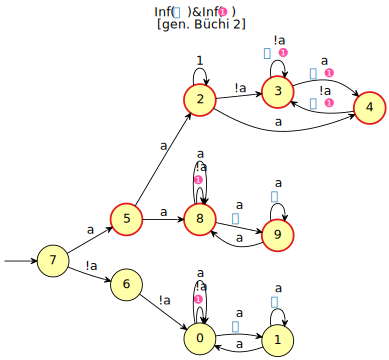

(False, False, True, True, True, True, False, False, True, True)


In [26]:
sistates2 = spot.make_stutter_invariant_forward_closed_inplace(ex1, sistates)
spot.highlight_stutter_invariant_states(ex1, None, 5)
display(ex1)
print(sistates2)

Now, state 0 is no longuer a problem.

In [27]:
spot.is_stutter_invariant_forward_closed(ex1, sistates2)

-1

Let's see how infrequently the set of stutter-invarant states is not closed.

In [28]:
import spot.gen as gen

In [29]:
# Let's consider the LTL formula from the following 5 sources,
# and restrict ourselves to formulas that are not stutter-invariant.
formulas = [ f for f in gen.ltl_patterns(gen.LTL_DAC_PATTERNS, 
                                         gen.LTL_EH_PATTERNS, 
                                         gen.LTL_HKRSS_PATTERNS, 
                                         gen.LTL_P_PATTERNS, 
                                         gen.LTL_SB_PATTERNS)
            if not f.is_syntactic_stutter_invariant() ]

aut_size = []
sistates_size = []
fwd_closed = []

fmt = "{:40.40} {:>6} {:>8} {:>10}"
print(fmt.format("formula", "states", "SIstates", "fwd_closed"))
for f in formulas:
    s = f.to_str()
    aut = spot.translate(f)
    aut_size.append(aut.num_states())
    sistates = spot.stutter_invariant_states(aut, f)
    sisz = sum(sistates)
    sistates_size.append(sisz)
    fc = spot.is_stutter_invariant_forward_closed(aut, sistates) == -1
    fwd_closed.append(fc)
    print(fmt.format(s, aut.num_states(), sisz, fc))

formula                                  states SIstates fwd_closed
Fp0 -> (!p0 U (!p0 & p1 & X(!p0 U p2)))       3        2          1
Fp0 -> (!p1 U (p0 | (!p1 & p2 & X(!p1 U       4        3          1
G!p0 | (!p0 U ((p0 & Fp1) -> (!p1 U (!p1      4        2          1
G((p0 & Fp1) -> (!p2 U (p1 | (!p2 & p3 &      4        1          1
G(p0 -> (Fp1 -> (!p1 U (p2 | (!p1 & p3 &      3        0          1
F(p0 & XFp1) -> (!p0 U p2)                    3        2          1
Fp0 -> (!(!p0 & p1 & X(!p0 U (!p0 & p2))      4        3          1
G!p0 | (!p0 U (p0 & (F(p1 & XFp2) -> (!p      4        2          1
G((p0 & Fp1) -> (!(!p1 & p2 & X(!p1 U (!      4        1          1
G(p0 -> ((!(!p1 & p2 & X(!p1 U (!p1 & p3      3        0          1
G((p0 & XFp1) -> XF(p1 & Fp2))                4        0          1
Fp0 -> (((p1 & X(!p0 U p2)) -> X(!p0 U (      6        2          1
G(p0 -> G((p1 & XFp2) -> X(!p2 U (p2 & F      5        0          1
G((p0 & Fp1) -> (((p2 & X(!p1 U p3)) ->      10 

There is no instance of set of stutter-invariant states that is not closed in these example formulas.

In [30]:
sum(fwd_closed), len(fwd_closed)

(63, 63)

Here is the percentage of stutter-invarant states.

In [31]:
100*sum(sistates_size)/sum(aut_size)

55.78947368421053